In [164]:
import aqt

from matplotlib import pyplot as plt
#import dash_bio
import pandas as pd
import seaborn as sns
import scipy

import itertools

In [165]:
def get_tags(items, filter_fn):
    tags = list(filter(
        filter_fn,
        set(
            itertools.chain(
                *(
                    item.tags
                    for item in items
                )
            )
        )
    ))
    return tags

In [166]:
def get_rtag_scores_for_card(card, rtag_filter_fn, weight_factor = 0.65):
    decay_factor = 1. - weight_factor
    rtag_scores = {}
    review_ids = model._state.review_ids_from_card_ids([card.id,])
    review_ids.sort()
    for review_id in review_ids:
        review = model.col.get_revlog_entry(review_id)
        rtags = list(filter(rtag_filter_fn, review.tags))
        # For every tag we've already seen,
        # we want a weighted decaying average of its score.
        # The reason is that if the user had trouble with a
        # particular tag during a particular review, but
        # not in the subsequent review, then we consider
        # that trouble point to be improved for the card,
        # and therefore we want to reduce its score.
        if review.button_chosen == 1:
          penalty_factor = 1.00
        elif review.button_chosen == 2:
          penalty_factor = 0.75
        elif review.button_chosen == 3:
          penalty_factor = 0.50
        else:
          penalty_factor = 0.25
        for rtag, score in rtag_scores.items():
            if rtag in rtags:
                score = (decay_factor*score) + penalty_factor*weight_factor
                rtags.remove(rtag)
            else:
                score = (decay_factor*score)
            rtag_scores[rtag] = score
        # For the remaining tags, this is the first time
        # we've seen them. The previous score for unseen
        # tags is zero, so we don't bother decaying the
        # previous score.
        for rtag in rtags:
            rtag_scores[rtag] = weight_factor
    return rtag_scores

In [167]:
def get_rtag_scores_for_cards(cards, rtag_filter_fn, weight_factor = 0.65):
    rtag_scores_dict = {}
    for card in cards:
        rtag_scores_dict[card.id] = get_rtag_scores_for_card(
            card,
            rtag_filter_fn,
            weight_factor
        )
    return rtag_scores_dict

In [168]:
def get_ntag_card_id_filter_fn(ntag):
    def ntag_card_id_filter_fn(card_id):
        card = model.col.get_card(card_id)
        return (ntag in card.note().tags) if card else False
    return ntag_card_id_filter_fn

In [169]:
def get_rtag_scores_for_ntag(ntag, rtag_scores_dict, empty_rtag_scores):
    rtag_score_sums_for_ntag = {}
    ntag_card_id_filter_fn = get_ntag_card_id_filter_fn(ntag)
    card_ids = rtag_scores_dict.keys()
    card_ids_for_ntag = list(filter(ntag_card_id_filter_fn, card_ids))
    for card_id in card_ids_for_ntag:
        rtag_scores_for_card_id = rtag_scores_dict[card_id]
        for rtag, score in rtag_scores_for_card_id.items():
            rtag_score_sum = rtag_score_sums_for_ntag.get(rtag, 0)
            rtag_score_sum += score
            rtag_score_sums_for_ntag[rtag] = rtag_score_sum
    num_cards_for_ntag = len(card_ids_for_ntag)
    rtag_score_for_ntag = empty_rtag_scores.copy()
    for rtag, rtag_score_sum in rtag_score_sums_for_ntag.items():
        rtag_score_for_ntag[rtag] = rtag_score_sum/num_cards_for_ntag
    return rtag_score_for_ntag

In [170]:
browser = aqt.dialogs._dialogs['Browser'][1]
table = browser.table
model = table._model

In [171]:
reviews = [model._state.get_review(item) for item in model._items]
cards = [model._state.get_card(item) for item in model._items]
notes = [model._state.get_note(item) for item in model._items]

In [172]:
rtag_filter_fn = lambda tag: tag.startswith('.feedback::trouble::')
rtags = get_tags(reviews, rtag_filter_fn)

# rtags

In [173]:
ntag_filter_fn = lambda tag: tag.startswith('.Texts::CET::')
ntags = get_tags(notes, ntag_filter_fn)

# ntags

In [174]:
rtag_scores_dict = get_rtag_scores_for_cards(cards, rtag_filter_fn)

# rtag_scores_dict

In [175]:
empty_rtag_scores = {rtag:0 for rtag in rtags}

# empty_rtag_scores

In [176]:
data = {
    ntag: list(
        get_rtag_scores_for_ntag(
            ntag,
            rtag_scores_dict,
            empty_rtag_scores,
        ).values()
    )
    for ntag in ntags
}

# data

In [177]:
df0 = pd.DataFrame(data)
df0.index = empty_rtag_scores.keys()
df = df0.T

# df

/mnt/Work/Repos/kaben/ankimath/out/pyenv/lib/python3.9/site-packages/seaborn/matrix.py:1113: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



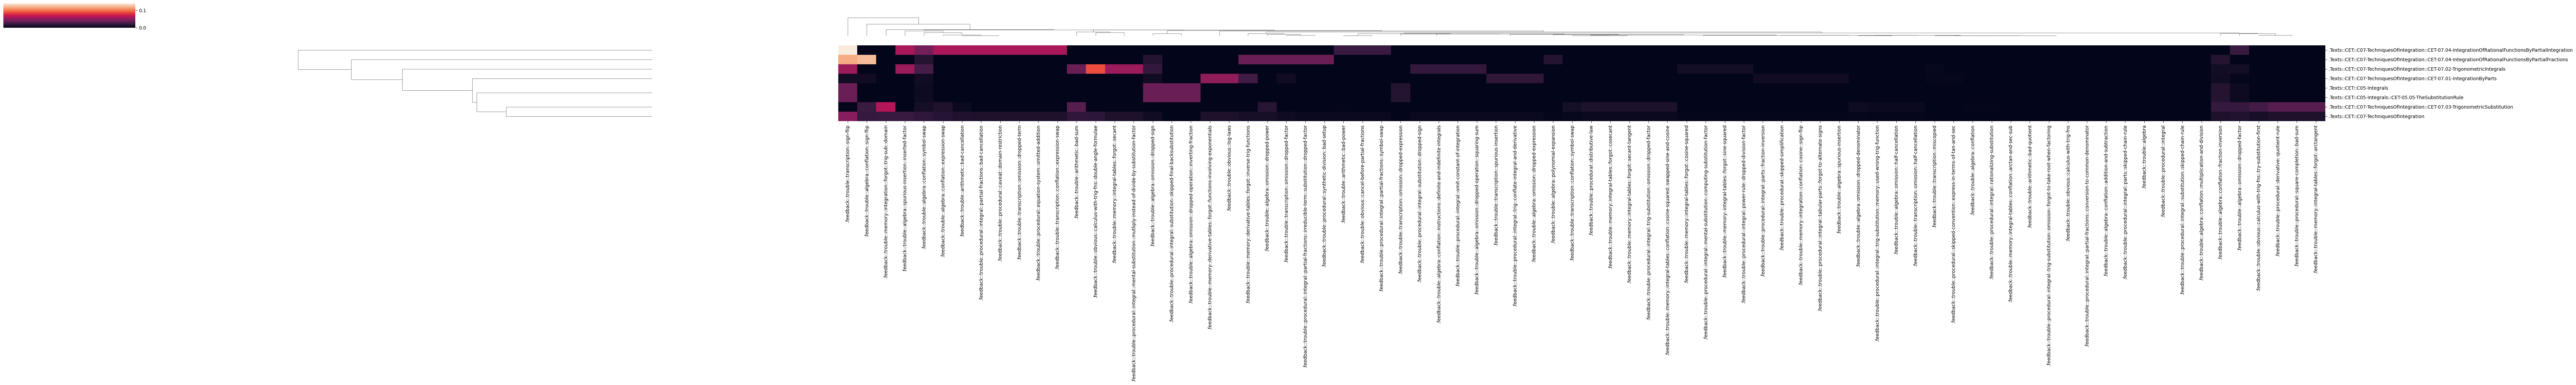

In [178]:
sns.clustermap(df, figsize=(len(rtags), len(ntags)/2))
plt.show()